<a href="https://colab.research.google.com/github/averyrop/Roswell-Park-s-DBBR-Cancer-Patient-Survival-Prediction-/blob/main/Roswell_Park's_DBBR_Cancer_Patient_Survival_Prediction_Team_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project** **Title**: **Roswell Park's DBBR Cancer Patient Survival Prediction Team #5**


This allows the data from the competition to be imported  to this notebook. The imported data is then "Unzipped" or decompressed so it's readable.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/MyDrive/aimdatathon/aimdatathon2020.zip

Archive:  gdrive/MyDrive/aimdatathon/aimdatathon2020.zip
  inflating: Background and Helpful Info.csv  
  inflating: Beverages.csv           
  inflating: Current Lifestyle.csv   
  inflating: DBBR Questionnaire Data Dictionary.csv  
  inflating: Exercise.csv            
  inflating: Family History.csv      
  inflating: Food Habits.csv         
  inflating: Foods.csv               
  inflating: Herbals.csv             
  inflating: Lifetime use of Supplements.csv  
  inflating: MedicalHistory.csv      
  inflating: MedicationUseHistory.csv  
  inflating: Multivitamins.csv       
  inflating: Nutrient Calc.csv       
  inflating: Smoking History.csv     
  inflating: Tumor Information_test.csv  
  inflating: Tumor Information_train.csv  
  inflating: Vitamins Minerals.csv   
  inflating: WomensHealth.csv        


### Data Management

Here I import my first four libraries. numpy and pandas are two common libraries for data manipulation and allow data to be read in, transformed, and analyzed easily. os is a library that allows files to be opened and extracted from folders, and plotly express will be used later for most of the plotting involved in this project

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import plotly.express as px

All of the files currently available are "filtered" and coralled, so that only the "csv" files are taken. The csv files are the ones associated with the competition and csv stands for "comma separated values" which describes how the data is stored in the file

In [ ]:
data_files = list(filter(lambda cont: 'csv' in cont,os.listdir()))

The competition files are then opened and turned into dataframes using "pandas" which was discussed earlier. Dataframes are like tables that allow organized storage of the data. Each file has a separate dataframe and all of these dataframes are stored in a list, so they can be gone through in order. The names of the variables (headers in the "tables") are changed to uppercase so that all common names, no matter if they were uppercase or lowercase, are recognized as the same thing.

In [ ]:
#Get a list of all files as dataframes
All_files = {}
for fil in data_files:

    key = fil.split('.')[0]
    All_files[key]=(pd.read_csv(fil))
    
    All_files[key].rename(str.upper,axis='columns',inplace=True)
        

Here is an example of a dataframe. Notice that every row is a different patient (identified by a barcode) and every column is a different variable (e.g. CURFRY, standing for how often do you fry foods) the values within the table are not necessarily readable at face value, as 1 might mean once a week, once a year, or it could stand for something completely different such as the phrase "I don't fry food"

In [ ]:
All_files['Current Lifestyle']

,QBARCODE,CURFRY,CURVEG,CURFRT,CUREX
0,100,1,5,5,2
1,102,0,2,2,2
2,104,0,5,5,1
3,105,6,4,5,0
4,106,2,5,4,1
...,...,...,...,...,...
1995,26291,1,2,1,2
1996,26502,2,3,3,3
1997,26534,2,3,4,0
1998,26605,1,5,2,1


####Data Preprocessing

#####Dataframe combination

Now that the data is loaded in, it needs many manipulations before it is useable. First we'll join the list of dataframes into one big dataframe.

First create a lambda function to ease the process. A lambda dictates the steps to a short process, so that the process can be performed with less typing in the future. It also allows other functions to use it repeatedly on lists of objects to achieve some goal, as will be seen shortly

In [ ]:
#Create a lambda function to help combine all dataframes
join_all = lambda df1,df2: df1.merge(right = df2, how = 'outer', on = 'QBARCODE' )                        

This functools library allows more flexibility in "functional programming" basically programming with lambdas

In [ ]:
import functools

In [ ]:
#Make a list of the Survey dataframes for use in reduce function
not_DBBR = list(filter(lambda f: 'DBBR' not in f,All_files.keys()))

Survey_list = []
for nam in All_files.keys():
  if nam in not_DBBR:
    Survey_list.append(All_files[nam])


Now using the lambda and functools we will essentially collapse our list of dataframes into one big dataframe, making sure patient data is associated with the right patient based on the 'QBARCODE' column that is in each dataframe. We also set aside a separate list of the barcodes and the patient statuses, the variable we are trying to predict, for convenience later

In [ ]:
#Combine all surveys into one, make a separate dataframe with the classes of the training set, so it can eventually be omitted from the dataframe of predictors
Combined_df = functools.reduce(join_all,Survey_list)

Class = pd.DataFrame(Combined_df[['QBARCODE','PATIENTSTATUS']])
barcs = pd.DataFrame(Combined_df['QBARCODE'])

Here the big dataframe can be seen. It has 2000 rows (one for each patient) and 1218 columns (basically one for each question the patient answered).

In [ ]:
Combined_df

,QBARCODE,ENERGY,PROTEIN,TOTAL LIPID (FAT),"CARBOHYDRATE, BY DIFFERENCE",TOTAL DIETARY FIBER,TOTAL SUGARS,CALCIUM,IRON_x,MAGNESIUM,PHOSPHORUS,POTASSIUM,SODIUM,ZINC_x,COPPER,MANGANESE,SELENIUM,VITAMIN A (IU),VITAMIN A (RAE),RETINOL,BETA-CAROTENE,ALPHA-CAROTENE,BETA-CRYPTOXANTHIN,LYCOPENE,LUTEIN + ZEAXANTHIN,VITAMIN D,VITAMIN K,ALPHA-TOCOPHEROL (VITAMIN E),ADDED VITAMIN E,BETA-TOCOPHEROL,GAMMA-TOCOPHEROL,DELTA-TOCOPHEROL,"VITAMIN C, TOTAL ASCORBIC ACID",THIAMIN,RIBOFLAVIN,NIACIN,PANTOTHENIC ACID,VITAMIN B6,"FOLATE, TOTAL",FOLIC ACID,...,MELANYC,MELSON,MELDAU,LEUKANYC,LEUKSON,LEUKDAU,SARCANYC,SARCSON,SARCDAU,OCX1CANY,OCX1SON,OCX1DAU,OCX1C,OCX1CSTD,OCX2CANY,OCX2SON,OCX2DAU,OCX2C,OCX2CSTD,FDEG_CA,FDEG_BR,FDEG_OV,FDEG_UT,FDEG_LUNG,FDEG_COLORECT,FDEG_BLADDER,FDEG_PROSTATE,FDEG_PANCREAS,FDEG_MELA,FDEG_LEUK,FDEG_SARC,FDEG_OTHERCA,EVRMLTI,YRSMLTI,EVRVITC,YRSVITC,EVRVITE,YRSVITE,EVRCALC,YRSCALC
0,100,2611.437774,120.763868,83.299809,352.943254,23.648236,172.397855,2354.567345,16.565900,497.124902,2686.897982,6378.457012,3915.600708,15.836562,1.771355,3.721760,133.621758,12277.464280,1662.768935,1261.748256,3769.526366,1193.344312,64.057955,4443.933750,1459.006491,648.131964,99.198994,10.693825,0.00000,0.120657,7.706899,1.719991,194.201626,2.264810,5.528555,27.209536,10.042321,3.269917,467.939304,150.057857,...,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,NaN,NaN,1,0,0,0,0,0,1,0,0,1,0,0,1,1,5,1,2,1,1,1,2
1,102,3289.887079,115.554945,136.265284,410.163350,26.031804,141.958303,1414.942384,23.162942,492.534682,2082.546484,6154.418091,4788.072918,18.626557,2.314886,4.700060,138.425411,8186.595714,852.673027,541.793429,3018.823637,699.831143,67.865321,16802.355625,1832.360250,222.935000,109.930591,15.657335,2.53125,0.110359,5.349804,1.116173,295.787600,2.927375,4.323975,44.745806,12.184370,4.321595,591.275305,206.375714,...,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,NaN,NaN,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,66,1,1,1,1
2,104,826.437009,34.843074,31.418111,102.186425,5.854263,21.392043,335.060640,6.922756,141.952095,544.075080,1510.746685,1637.709479,4.381799,0.878431,1.960019,47.563775,1588.507530,208.624551,157.994131,386.746143,57.979321,21.042268,1660.333393,390.621429,3.348571,22.520874,3.111250,0.00000,0.024251,1.207680,0.236076,65.151461,0.703700,1.010162,11.403827,2.089313,0.848106,172.773875,58.837232,...,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5,1,1,0,66,1,1
3,105,2400.432048,99.299475,83.565226,315.729899,22.720838,99.060080,1876.663622,18.569845,487.534547,2024.256825,5543.876320,4200.240171,15.716069,1.584938,4.313135,112.213345,12308.998215,1265.038405,782.505952,5332.783602,431.107964,18.876643,4693.369732,6586.181875,341.804643,319.917371,6.100825,0.00000,0.100438,3.207160,0.672991,116.800409,2.634746,5.374435,31.063096,12.154166,2.718773,557.384016,194.698571,...,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,NaN,NaN,1,1,0,0,0,0,0,0,0,0,0,0,0,1,5,1,5,0,66,1,99
4,106,2493.679652,113.835182,119.499360,244.865142,16.965896,116.426268,1684.989155,14.349756,403.145982,2190.646955,4820.884033,3687.668232,14.452861,1.328427,3.408585,143.965290,8483.816860,1177.532057,906.938932,2397.095250,628.010179,121.201786,3069.808214,2815.263286,398.620357,105.691154,11.717813,0.00000,0.184950,9.927402,2.169037,100.721685,1.783094,5.143509,24.165364,12.476470,2.276671,481.859815,121.716429,...,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,NaN,NaN,1,0,0,0,0,0,0,1,0,1,0,0,0,1,5,0,66,0,66,0,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,26291,1172.701223,43.512830,54.796257,127.530264,7.938282,29.784761,547.824920,7.663847,155.051095,796.087357,1900.278991,2219.367920,6.542374,0.699224,1.667143,57.234330,4043.010429,304.960750,139.703560,1432.243631,508.062929,25

#####Dealing with null values

Now we deal with questions that patients did not answer. All of the data is checked, and any questions that were not answered by too many people (over 30%) are set aside to be deleted, as they may not give useful info. If some people did not answer, but the amount is less than 30% these are set aside for different treatment.

In [ ]:
#Want to be able to see how many patients for each column did not fill in an answer for the column.
#This loop only adds columns that have any null answers
#Because of the test train split two separate columns were made for answers that are in both, such as primary site x and y. These were not added because the columns being split make NAs appear
#Patient Status only exists for train and thus has nas for the train people, so it is also not being counted for this
#Make a list for columns with too many NAs, to omit.
#Make a list of columns with few NAs, to fill
omit = []
NA_dict = {}
NA_fill = []
for column in Combined_df:
    
    percent_null =  Combined_df[column].isnull().sum()/2000
    
    if percent_null != 0 and not ('x' in column or 'y' in column) and column != 'PATIENTSTATUS':
    
        NA_dict[column] = percent_null
        
        if percent_null > .3:
            omit.append(column)
        else:
            NA_fill.append(column)
        

Here the chosen columns are deleted and the outcome variable (patient status) is finally deleted, so that the computer will have to guess it later when training the model.

In [ ]:
#Drop columns with too many NAs
NA_dropped = Combined_df.drop(columns = omit)

#Take out class we're trying to predict
Class_dropped = NA_dropped.drop(columns = ['PATIENTSTATUS'])

Now we take steps to fill in the unanswered questions that were less than 30% with the most frequent answer given by the people that did answer, this most frequent answer statistically being called the mode. While this is not accurate, it is a good guess at what the people might have said, given that a high proportion of people said it.

In [ ]:
#Make a dictionary so we can easily fill NAs in certain columns with mode of column
mode_list = [Class_dropped[col].mode()[0] for col in NA_fill ]
NA_fill_dict = dict(zip(NA_fill,mode_list))

In [ ]:
#Fill NAs in specified columns
NA_filled = Class_dropped.fillna(value = NA_fill_dict)

Here the overall dataframe minus the dropped columns and with filled values can be seen. While we can't exactly see where values were filled, we can see that there are less columns, as we now have 1113 instead of 1218

In [ ]:
NA_filled

,QBARCODE,ENERGY,PROTEIN,TOTAL LIPID (FAT),"CARBOHYDRATE, BY DIFFERENCE",TOTAL DIETARY FIBER,TOTAL SUGARS,CALCIUM,IRON_x,MAGNESIUM,PHOSPHORUS,POTASSIUM,SODIUM,ZINC_x,COPPER,MANGANESE,SELENIUM,VITAMIN A (IU),VITAMIN A (RAE),RETINOL,BETA-CAROTENE,ALPHA-CAROTENE,BETA-CRYPTOXANTHIN,LYCOPENE,LUTEIN + ZEAXANTHIN,VITAMIN D,VITAMIN K,ALPHA-TOCOPHEROL (VITAMIN E),ADDED VITAMIN E,BETA-TOCOPHEROL,GAMMA-TOCOPHEROL,DELTA-TOCOPHEROL,"VITAMIN C, TOTAL ASCORBIC ACID",THIAMIN,RIBOFLAVIN,NIACIN,PANTOTHENIC ACID,VITAMIN B6,"FOLATE, TOTAL",FOLIC ACID,...,PROSSON,PANCANYC,PANCSON,PANCDAU,MELANYC,MELSON,MELDAU,LEUKANYC,LEUKSON,LEUKDAU,SARCANYC,SARCSON,SARCDAU,OCX1CANY,OCX1SON,OCX1DAU,OCX2CANY,OCX2SON,OCX2DAU,FDEG_CA,FDEG_BR,FDEG_OV,FDEG_UT,FDEG_LUNG,FDEG_COLORECT,FDEG_BLADDER,FDEG_PROSTATE,FDEG_PANCREAS,FDEG_MELA,FDEG_LEUK,FDEG_SARC,FDEG_OTHERCA,EVRMLTI,YRSMLTI,EVRVITC,YRSVITC,EVRVITE,YRSVITE,EVRCALC,YRSCALC
0,100,2611.437774,120.763868,83.299809,352.943254,23.648236,172.397855,2354.567345,16.565900,497.124902,2686.897982,6378.457012,3915.600708,15.836562,1.771355,3.721760,133.621758,12277.464280,1662.768935,1261.748256,3769.526366,1193.344312,64.057955,4443.933750,1459.006491,648.131964,99.198994,10.693825,0.00000,0.120657,7.706899,1.719991,194.201626,2.264810,5.528555,27.209536,10.042321,3.269917,467.939304,150.057857,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,1,5,1,2,1,1,1,2
1,102,3289.887079,115.554945,136.265284,410.163350,26.031804,141.958303,1414.942384,23.162942,492.534682,2082.546484,6154.418091,4788.072918,18.626557,2.314886,4.700060,138.425411,8186.595714,852.673027,541.793429,3018.823637,699.831143,67.865321,16802.355625,1832.360250,222.935000,109.930591,15.657335,2.53125,0.110359,5.349804,1.116173,295.787600,2.927375,4.323975,44.745806,12.184370,4.321595,591.275305,206.375714,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,66,1,1,1,1
2,104,826.437009,34.843074,31.418111,102.186425,5.854263,21.392043,335.060640,6.922756,141.952095,544.075080,1510.746685,1637.709479,4.381799,0.878431,1.960019,47.563775,1588.507530,208.624551,157.994131,386.746143,57.979321,21.042268,1660.333393,390.621429,3.348571,22.520874,3.111250,0.00000,0.024251,1.207680,0.236076,65.151461,0.703700,1.010162,11.403827,2.089313,0.848106,172.773875,58.837232,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5,1,1,0,66,1,1
3,105,2400.432048,99.299475,83.565226,315.729899,22.720838,99.060080,1876.663622,18.569845,487.534547,2024.256825,5543.876320,4200.240171,15.716069,1.584938,4.313135,112.213345,12308.998215,1265.038405,782.505952,5332.783602,431.107964,18.876643,4693.369732,6586.181875,341.804643,319.917371,6.100825,0.00000,0.100438,3.207160,0.672991,116.800409,2.634746,5.374435,31.063096,12.154166,2.718773,557.384016,194.698571,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,5,1,5,0,66,1,99
4,106,2493.679652,113.835182,119.499360,244.865142,16.965896,116.426268,1684.989155,14.349756,403.145982,2190.646955,4820.884033,3687.668232,14.452861,1.328427,3.408585,143.965290,8483.816860,1177.532057,906.938932,2397.095250,628.010179,121.201786,3069.808214,2815.263286,398.620357,105.691154,11.717813,0.00000,0.184950,9.927402,2.169037,100.721685,1.783094,5.143509,24.165364,12.476470,2.276671,481.859815,121.716429,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,5,0,66,0,66,0,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,26291,1172.701223,43.512830,54.796257,127.530264,7.938282,29.784761,547.824920,7.663847,155.051095,796.087357,1900.278991,2219.367920,6.542374,0.699224,1.667143,57.234330,4043.010429,304.960750,139.703560,1432.243631,508.062929,25.099607,3497.270357,396.717893,56.855

#####Recombining test and train

In order to validate the accuracy of the model that will be trained on this data a certain subset of this data needs to be set aside for validation. This setting aside creates a "test" and a "training" set. The data provided by the competition had separate files for some of the variables based on whether the patient is in the test or the training set, but the separate files contain the same information about the patient (e.g. how many pets they own). As a result there are separate columns in our overall dataframe for the same data, a cell in the column just being blank depending on if you are test or training set. This is not good as the model will see these as separate pieces of information, when they should be acknowledged as the same. This section recombines the common test and training data.

First find which columns need to be fixed

In [ ]:
#Find which columns have x and y in them in order to tell where the test/ train overlap happened. Turns out there were also multiple columns called iron and zinc.
#The iron and zinc ones are actually different though, so we don't need to do anythin with them

xy_list = sorted(list(filter(lambda col: ('x' in col or 'y' in col) ,NA_filled)))


In [ ]:
#Make a list of the dataframes of the xys
xy_dfs = []
for col in xy_list:
    xy_dfs.append(pd.DataFrame(NA_filled[col]))

Next we recombine the columns that need combining. It turns out that my method of identifying the culprit columns was not foolproof, so steps are taken to exclude the columns that need to be combined (i.e. columns relating to iron and zinc levels in the patients)

In [ ]:
#Combine the x and y column into one column for the columns that are separated in the test/ train split

comb_test_train = pd.DataFrame(index = range(NA_filled.shape[0]))

for i in range(0,len(xy_dfs)-1, 2):
    
    col = xy_list[i]
    
    if 'IRON' not in col and 'ZINC' not in col:
        
        xy_dfs[i+1].columns = xy_dfs[i].columns
        
        comb_df = xy_dfs[i].combine_first(xy_dfs[i+1])
        
        comb_test_train = pd.concat([comb_test_train,comb_df],axis=1)
        

In [ ]:
# Make list of columns in test and training surveys, to be omitted from overall dataframe
test_train_list = list(filter(lambda col: ('IRON' not in col and 'ZINC'not in col),xy_list))

In [ ]:
# Drop desired columns from overall dataframe. Also record which Barcodes are test and train for easy merges later
Test_train_dropped = NA_filled.drop(test_train_list,axis='columns')
train_barcodes = pd.DataFrame(All_files['Tumor Information_train']['QBARCODE'])
test_barcodes =  pd.DataFrame(All_files['Tumor Information_test']['QBARCODE'])

In [ ]:
#Make dataframe with combined test and train  data back in 

Full_pred = pd.concat([Test_train_dropped,comb_test_train],axis=1)

Here we can see the results of the combination. The rightmost columns of this column are the new combined version of the separated columns and we can see that we now have 1109 columns do the the combinations.

In [ ]:
Full_pred

,QBARCODE,ENERGY,PROTEIN,TOTAL LIPID (FAT),"CARBOHYDRATE, BY DIFFERENCE",TOTAL DIETARY FIBER,TOTAL SUGARS,CALCIUM,IRON_x,MAGNESIUM,PHOSPHORUS,POTASSIUM,SODIUM,ZINC_x,COPPER,MANGANESE,SELENIUM,VITAMIN A (IU),VITAMIN A (RAE),RETINOL,BETA-CAROTENE,ALPHA-CAROTENE,BETA-CRYPTOXANTHIN,LYCOPENE,LUTEIN + ZEAXANTHIN,VITAMIN D,VITAMIN K,ALPHA-TOCOPHEROL (VITAMIN E),ADDED VITAMIN E,BETA-TOCOPHEROL,GAMMA-TOCOPHEROL,DELTA-TOCOPHEROL,"VITAMIN C, TOTAL ASCORBIC ACID",THIAMIN,RIBOFLAVIN,NIACIN,PANTOTHENIC ACID,VITAMIN B6,"FOLATE, TOTAL",FOLIC ACID,...,MELANYC,MELSON,MELDAU,LEUKANYC,LEUKSON,LEUKDAU,SARCANYC,SARCSON,SARCDAU,OCX1CANY,OCX1SON,OCX1DAU,OCX2CANY,OCX2SON,OCX2DAU,FDEG_CA,FDEG_BR,FDEG_OV,FDEG_UT,FDEG_LUNG,FDEG_COLORECT,FDEG_BLADDER,FDEG_PROSTATE,FDEG_PANCREAS,FDEG_MELA,FDEG_LEUK,FDEG_SARC,FDEG_OTHERCA,EVRMLTI,YRSMLTI,EVRVITC,YRSVITC,EVRVITE,YRSVITE,EVRCALC,YRSCALC,GRADE_x,HISTOLOGY_x,PRIMARYSITE_x,SEERSUMMSTAGE2000_x
0,100,2611.437774,120.763868,83.299809,352.943254,23.648236,172.397855,2354.567345,16.565900,497.124902,2686.897982,6378.457012,3915.600708,15.836562,1.771355,3.721760,133.621758,12277.464280,1662.768935,1261.748256,3769.526366,1193.344312,64.057955,4443.933750,1459.006491,648.131964,99.198994,10.693825,0.00000,0.120657,7.706899,1.719991,194.201626,2.264810,5.528555,27.209536,10.042321,3.269917,467.939304,150.057857,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,1,5,1,2,1,1,1,2,"Grade III: Poorly differentiated, dedifferenti...","Infiltrating duct carcinoma, NOS","Breast, lower-inner quadrant",3.0
1,102,3289.887079,115.554945,136.265284,410.163350,26.031804,141.958303,1414.942384,23.162942,492.534682,2082.546484,6154.418091,4788.072918,18.626557,2.314886,4.700060,138.425411,8186.595714,852.673027,541.793429,3018.823637,699.831143,67.865321,16802.355625,1832.360250,222.935000,109.930591,15.657335,2.53125,0.110359,5.349804,1.116173,295.787600,2.927375,4.323975,44.745806,12.184370,4.321595,591.275305,206.375714,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,66,1,1,1,1,"Grade II: Mod diff, mod well diff, intermediat...",Infiltrating duct and lobular carcinoma,"Breast, upper-outer quadrant",1.0
2,104,826.437009,34.843074,31.418111,102.186425,5.854263,21.392043,335.060640,6.922756,141.952095,544.075080,1510.746685,1637.709479,4.381799,0.878431,1.960019,47.563775,1588.507530,208.624551,157.994131,386.746143,57.979321,21.042268,1660.333393,390.621429,3.348571,22.520874,3.111250,0.00000,0.024251,1.207680,0.236076,65.151461,0.703700,1.010162,11.403827,2.089313,0.848106,172.773875,58.837232,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5,1,1,0,66,1,1,"Grade III: Poorly differentiated, dedifferenti...","Infiltrating duct carcinoma, NOS","Breast, upper-outer quadrant",3.0
3,105,2400.432048,99.299475,83.565226,315.729899,22.720838,99.060080,1876.663622,18.569845,487.534547,2024.256825,5543.876320,4200.240171,15.716069,1.584938,4.313135,112.213345,12308.998215,1265.038405,782.505952,5332.783602,431.107964,18.876643,4693.369732,6586.181875,341.804643,319.917371,6.100825,0.00000,0.100438,3.207160,0.672991,116.800409,2.634746,5.374435,31.063096,12.154166,2.718773,557.384016,194.698571,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,5,1,5,0,66,1,99,"Grade I: Well differentiated, differentiated, NOS","Infiltrating duct carcinoma, NOS","Breast, lower-inner quadrant",1.0
4,106,2493.679652,113.835182,119.499360,244.865142,16.965896,116.426268,1684.989155,14.349756,403.145982,2190.646955,4820.884033,3687.668232,14.452861,1.328427,3.408585,143.965290,8483.816860,1177.532057,906.938932,2397.095250,628.010179,121.201786,3069.808214,2815.263286,398.620357,105.691154,11.717813,0.00000,0.184950,9.927402,2.169037,100.721685,1.783094,5.143509,24.165364,12.476470,2.276671,481.859815,121.716429,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,5,0,66,0,66,0,66,"Grade III: Poorly differentiated, dedifferenti...","Infiltrating duct carcinoma, NOS","Breast, upper-inner quadrant",1.0
...,

### Study Design


Next some demographics of the data are explored to view what kinds of biases may be ingrained in the analysis, as well as to perhaps get an idea of some factors that may affect the outcome (Patient status) Only the data associated with the training set are observed, as this is the data that will influence the creation of the model, while the test set will only be used to check accuracy

#####Survival proportions

First visualization will show how many of the training patients are in each category of survival, 1 being survived, 0 being dies. This will inform us of what the values should look like. Here the data that we're interested in (the patient status of the training set) is pulled into a dataframe

In [ ]:
stud_des_df = train_barcodes.merge(Full_pred, on = 'QBARCODE').merge(Class,on='QBARCODE')

Next we finally use the plotly express library imported so long ago. Plotly allows for lots of different visualizations to be made from data, and plotly express is a more convenient version, allowing for quick and easy plots to be made without many details. the tradeoff is that you can't get as in depth with customization as you can with regular plotly, but that's okay for our needs. As may be surmised, px. pie makes pie graphs. 

In [ ]:
##This shows that 62% of the people in training data survived (1)

px.pie(data_frame = stud_des_df, names = 'PATIENTSTATUS',title = 'Survival breakdown')

The results show that about 60% of people live. This means that any variables we explore should have this same 60% surviving. For example if we look at males and females separately 60% of males should survive and so should 60% of females. If it turns out that 80% of males are surviving while only 40% of females are this is a good indication that sex may be an important variable in determining patient outcome.

#####Race Proportions

Next we look at what races the patients who provided information are. Again we pull out all of the data relating to race and make it into a dataframe

In [ ]:
#Pulling data for race breakdown
race_list = list(filter(lambda n: 'RAC' in n,list(stud_des_df.columns)))

race_df = stud_des_df[race_list]

In [ ]:
#Still pulling data for race breakdown
racs = []
for row in race_df.iterrows():

  racs.append(list(row[1].index[row[1]==1]))

The pie chart below, made using plotly express, shows that a vast majority of the surveyed patients were race 1, corresponding to white. the other corresponding values are detailed in one of the files containing info about all of the questions, and are translated below in green, but the point is that this data  is predominantly white, and as such the model may not be applicable to other races

In [ ]:
#Shows that 93% of participants were race 1 (White)
# 4.5% were Race 2 (Black)
# .625% Race 3 (American Indian/Alaskan Native)
# .438% Race 4 (Asian)
# .125% Race 5 (Native Hawaiian/other Pacific Islander)

px.pie(names = racs, title = 'Race breakdown')

/usr/local/lib/python3.6/dist-packages/plotly/express/_core.py:998: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



#####Age Spread





Next we look at the age spread and how it affects patient outcome. the data is normally distributed with a mean, or average, of about 62 overall. the data is split, blue for survivors and red for the dead. grouped based on age. 

In [ ]:
#Approximately normal distribution with a mean at about 62 overall
px.histogram(data_frame = stud_des_df, x = 'AGE',title = 'Age breakdown',color = 'PATIENTSTATUS', barmode = 'group')

It can be seen that to the left of about 67, blue is much higher, but above 67, red is mostly taller. This shows that patient status is at least partially dependent on age, and older people are generally more susceptible to death. Visually there appear to be two different means, one at 60 for the survivors, and one at 70 for the dead. 

#####Income Spread

The last visualiztion shows patient income. First data is pulled as usual

In [ ]:
#Organize survival and income data
inc_list = list(stud_des_df['HHINC'])

inc_dict = {1:'< 10k',2:'10k-25k',3:'25k-50k',4:'50k-75k',5:'> 75k',6:'Refuse to answer',77:'Don\'t know',99:'No response'}

inc_map = list(map(lambda ele: inc_dict[ele],inc_list))
stat_list = list(stud_des_df['PATIENTSTATUS'])

i_s_dict = {'inc' :inc_map,'stat' : stat_list}
inc_stat_df = pd.DataFrame(data = i_s_dict)


Here the incomes are plotted using a histogram again. 

In [ ]:
#Shows the incomes grouped based on survival(blue live, red die)
# As 60% of paitents lived itd make sense for blue to be higher, about 1.5x the height of the corresponding red
#This shows those who made under 25k were more likely to die, as the percentages of living to dead are mismatched 
px.histogram(data_frame=inc_stat_df, x = 'inc', color = 'stat', barmode = 'group', title = 'Income Breakdown',category_orders=dict(inc=['< 10k','10k-25k','25k-50k','50k-75k','> 75k','Refuse to answer','Don\'t know','No response']))

As mentioned earlier there are more survivors than dead overall, so each bar would have blue higher if this variable were unimportant, but under $25,000 of annual income deaths are more common than survival. This shows that patient survival is related to income. Furthermore the mismatch between survival and death increases as you go from 25k up to above 75k, further illustrating this point.

###Train and Test Data Pre-processing

Now some more preprocessing is done to prepare the data for modelling. First the data is split into the training and test set

In [ ]:
#Identify Data that's in training set
Full_pred_train = train_barcodes.merge(Full_pred, on = 'QBARCODE')

#####Encode

Since the computer runs on math, any columns that are not numbers need to be turned into numbers.  This next part "encodes" the data, specifically meaning that a new column is made for each unique non numeric answer and a 1 is put into the patients row if they answered this option

In [ ]:
#identify data that needs encoding
str_list = []
for col in Full_pred:
    
    if Full_pred[col].dtype == 'O':
        
        str_list.append(col)
        

In [ ]:
#Separate data that needs encoding
pre_enc = Full_pred[str_list]

Here we import some functions from the sklearn library, a library for machine learning. The one hot encoder for the encoding, and the standard scaler which will be discussed later

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

The encoding is performed on the columns that need it, separately from the overall dataframe. The new columns are then added to the original dataframe, dropping the ones that they're replacing.

In [ ]:
#Encode string columns

oh_enc = OneHotEncoder().fit(pre_enc)

enc_names = oh_enc.get_feature_names()

enc = pd.DataFrame(oh_enc.transform(pre_enc).toarray(),columns = enc_names)

In [ ]:
#Recombine encoded columns, and remove barcode so it doesn't get scaled in next block
enc_frame = pd.concat([Full_pred.drop(str_list,axis=1), enc],axis = 1)
enc_frame.drop('QBARCODE',axis=1,inplace=True)

The new encoded dataframe is shown below. Notice that there are now 2688 columns, a huge jump from the last overall dataframe we looked at. This is because every individual option from the non numeric columns was tacked on as a new column.

In [ ]:
enc_frame

,ENERGY,PROTEIN,TOTAL LIPID (FAT),"CARBOHYDRATE, BY DIFFERENCE",TOTAL DIETARY FIBER,TOTAL SUGARS,CALCIUM,IRON_x,MAGNESIUM,PHOSPHORUS,POTASSIUM,SODIUM,ZINC_x,COPPER,MANGANESE,SELENIUM,VITAMIN A (IU),VITAMIN A (RAE),RETINOL,BETA-CAROTENE,ALPHA-CAROTENE,BETA-CRYPTOXANTHIN,LYCOPENE,LUTEIN + ZEAXANTHIN,VITAMIN D,VITAMIN K,ALPHA-TOCOPHEROL (VITAMIN E),ADDED VITAMIN E,BETA-TOCOPHEROL,GAMMA-TOCOPHEROL,DELTA-TOCOPHEROL,"VITAMIN C, TOTAL ASCORBIC ACID",THIAMIN,RIBOFLAVIN,NIACIN,PANTOTHENIC ACID,VITAMIN B6,"FOLATE, TOTAL",FOLIC ACID,FOOD FOLATE,...,x6_Rectosigmoid colon,x6_Rectosigmoid junction,"x6_Rectum, NOS","x6_Rectum/anus/anal canal, overlapping lesion",x6_Renal pelvis,x6_Retroperitoneum,"x6_Sigmoid, NOS",x6_Skin of lower limb and hip,x6_Skin of trunk,x6_Skin of upper limb and shoulder,x6_Skin of vulva,x6_Soft tissues of upper limb/shoulder,x6_Soft tissues of abdomen,x6_Soft tissues of head/face/neck,x6_Soft tissues of lower limb/hip,x6_Soft tissues of pelvis,x6_Soft tissues of thorax,x6_Soft tissues of toe,"x6_Soft tissues of trunk, NOS",x6_Spermatic cord,"x6_Stomach, NOS","x6_Stomach, body of","x6_Stomach, lesser curvature, NOS","x6_Stomach, overlapping lesion",x6_Supraglottis,x6_Temporal lobe,"x6_Testis, undescended",x6_Thymus,x6_Thyroid gland,"x6_Tongue, NOS","x6_Tongue, base of, NOS","x6_Tongue, dorsal surface, NOS","x6_Tongue, ventral surface, NOS","x6_Tonsil, NOS",x6_Ureter,x6_Urethra,"x6_Urinary system, NOS","x6_Vagina, NOS","x6_Vulva, NOS","x6_Vulva, overlapping lesion"
0,2611.437774,120.763868,83.299809,352.943254,23.648236,172.397855,2354.567345,16.565900,497.124902,2686.897982,6378.457012,3915.600708,15.836562,1.771355,3.721760,133.621758,12277.464280,1662.768935,1261.748256,3769.526366,1193.344312,64.057955,4443.933750,1459.006491,648.131964,99.198994,10.693825,0.00000,0.120657,7.706899,1.719991,194.201626,2.264810,5.528555,27.209536,10.042321,3.269917,467.939304,150.057857,304.870732,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3289.887079,115.554945,136.265284,410.163350,26.031804,141.958303,1414.942384,23.162942,492.534682,2082.546484,6154.418091,4788.072918,18.626557,2.314886,4.700060,138.425411,8186.595714,852.673027,541.793429,3018.823637,699.831143,67.865321,16802.355625,1832.360250,222.935000,109.930591,15.657335,2.53125,0.110359,5.349804,1.116173,295.787600,2.927375,4.323975,44.745806,12.184370,4.321595,591.275305,206.375714,339.165305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,826.437009,34.843074,31.418111,102.186425,5.854263,21.392043,335.060640,6.922756,141.952095,544.075080,1510.746685,1637.709479,4.381799,0.878431,1.960019,47.563775,1588.507530,208.624551,157.994131,386.746143,57.979321,21.042268,1660.333393,390.621429,3.348571,22.520874,3.111250,0.00000,0.024251,1.207680,0.236076,65.151461,0.703700,1.010162,11.403827,2.089313,0.848106,172.773875,58.837232,103.310036,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2400.432048,99.299475,83.565226,315.729899,22.720838,99.060080,1876.663622,18.569845,487.534547,2024.256825,5543.876320,4200.240171,15.716069,1.584938,4.313135,112.213345,12308.998215,1265.038405,782.505952,5332.783602,431.107964,18.876643,4693.369732,6586.181875,341.804643,319.917371,6.100825,0.00000,0.100438,3.207160,0.672991,116.800409,2.634746,5.374435,31.063096,12.154166,2.718773,557.384016,194.698571,352.329641,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2493.679652,113.835182,119.499360,244.865142,16.965896,116.426268,1684.989155,14.349756,403.145982,2190.646955,4820.884033,3687.668232,14.452861,1.328427,3.408585,

#####Scale

Now the data needs to be scaled down to so that the average of every column is 0, and the variance of every column is 1. This is necessary so that the ML models can read the data properly. Once these transformations are done, the data is considered "unit normal". The standard scaler function imported earlier will achieve this.

In [ ]:
#Scale values, so ML model can read data well
scale_fit = StandardScaler().fit(enc_frame)

scale_frame = pd.DataFrame(scale_fit.transform(enc_frame),columns = enc_frame.columns)

Below is the new scaled dataframe. The data is essentially the same as after encoding, just scaled down so that all of the values are much lower, close to 0.

In [ ]:
scale_frame

,ENERGY,PROTEIN,TOTAL LIPID (FAT),"CARBOHYDRATE, BY DIFFERENCE",TOTAL DIETARY FIBER,TOTAL SUGARS,CALCIUM,IRON_x,MAGNESIUM,PHOSPHORUS,POTASSIUM,SODIUM,ZINC_x,COPPER,MANGANESE,SELENIUM,VITAMIN A (IU),VITAMIN A (RAE),RETINOL,BETA-CAROTENE,ALPHA-CAROTENE,BETA-CRYPTOXANTHIN,LYCOPENE,LUTEIN + ZEAXANTHIN,VITAMIN D,VITAMIN K,ALPHA-TOCOPHEROL (VITAMIN E),ADDED VITAMIN E,BETA-TOCOPHEROL,GAMMA-TOCOPHEROL,DELTA-TOCOPHEROL,"VITAMIN C, TOTAL ASCORBIC ACID",THIAMIN,RIBOFLAVIN,NIACIN,PANTOTHENIC ACID,VITAMIN B6,"FOLATE, TOTAL",FOLIC ACID,FOOD FOLATE,...,x6_Rectosigmoid colon,x6_Rectosigmoid junction,"x6_Rectum, NOS","x6_Rectum/anus/anal canal, overlapping lesion",x6_Renal pelvis,x6_Retroperitoneum,"x6_Sigmoid, NOS",x6_Skin of lower limb and hip,x6_Skin of trunk,x6_Skin of upper limb and shoulder,x6_Skin of vulva,x6_Soft tissues of upper limb/shoulder,x6_Soft tissues of abdomen,x6_Soft tissues of head/face/neck,x6_Soft tissues of lower limb/hip,x6_Soft tissues of pelvis,x6_Soft tissues of thorax,x6_Soft tissues of toe,"x6_Soft tissues of trunk, NOS",x6_Spermatic cord,"x6_Stomach, NOS","x6_Stomach, body of","x6_Stomach, lesser curvature, NOS","x6_Stomach, overlapping lesion",x6_Supraglottis,x6_Temporal lobe,"x6_Testis, undescended",x6_Thymus,x6_Thyroid gland,"x6_Tongue, NOS","x6_Tongue, base of, NOS","x6_Tongue, dorsal surface, NOS","x6_Tongue, ventral surface, NOS","x6_Tonsil, NOS",x6_Ureter,x6_Urethra,"x6_Urinary system, NOS","x6_Vagina, NOS","x6_Vulva, NOS","x6_Vulva, overlapping lesion"
0,0.775562,1.250977,0.316056,0.999139,0.674078,1.344663,1.631422,0.438642,1.065448,1.623827,1.050708,0.713178,0.754945,0.115776,0.494359,1.158943,0.541917,0.832710,0.820650,0.223967,0.509430,-0.085368,-0.094462,-0.103383,1.814183,0.037282,0.472168,-0.264590,0.868239,1.642141,2.121117,0.285808,0.888709,1.429091,0.366788,0.545980,0.812125,0.256749,0.018886,0.377322,...,-0.022366,-0.125475,-0.177368,-0.031639,-0.044766,-0.054855,-0.121299,-0.022366,-0.022366,-0.022366,-0.022366,-0.044766,-0.031639,-0.031639,-0.080886,-0.050063,-0.054855,-0.022366,-0.044766,-0.022366,-0.022366,-0.031639,-0.038759,-0.031639,-0.031639,-0.031639,-0.022366,-0.022366,-0.022366,-0.031639,-0.022366,-0.022366,-0.022366,-0.038759,-0.050063,-0.031639,-0.022366,-0.022366,-0.054855,-0.022366
1,1.467955,1.113765,1.504395,1.463277,0.929916,0.829075,0.404658,1.411397,1.036792,0.854105,0.950649,1.253865,1.219287,0.476803,1.140568,1.268513,-0.114375,-0.128463,-0.106455,-0.053471,-0.105511,-0.027796,2.071272,0.092242,0.037382,0.154247,1.319775,1.332504,0.679201,0.761872,0.987924,1.086793,1.709402,0.736422,1.815728,1.012912,1.681130,0.858887,0.535592,0.637624,...,-0.022366,-0.125475,-0.177368,-0.031639,-0.044766,-0.054855,-0.121299,-0.022366,-0.022366,-0.022366,-0.022366,-0.044766,-0.031639,-0.031639,-0.080886,-0.050063,-0.054855,-0.022366,-0.044766,-0.022366,-0.022366,-0.031639,-0.038759,-0.031639,-0.031639,-0.031639,-0.022366,-0.022366,-0.022366,-0.031639,-0.022366,-0.022366,-0.022366,-0.038759,-0.050063,-0.031639,-0.022366,-0.022366,-0.054855,-0.022366
2,-1.046124,-1.012327,-0.847966,-1.034860,-1.235828,-1.213085,-1.005223,-0.983269,-1.151858,-1.105343,-1.123290,-0.698473,-1.151486,-0.477326,-0.669344,-0.804024,-1.172897,-0.892623,-0.600684,-1.026209,-0.905288,-0.735818,-0.582270,-0.663182,-0.880219,-0.798445,-0.822691,-0.264590,-0.901382,-0.785026,-0.663763,-0.731726,-1.044977,-1.169116,-0.939165,-1.187648,-1.189025,-1.184277,-0.818046,-1.152554,...,-0.022366,-0.125475,-0.177368,-0.031639,-0.044766,-0.054855,-0.121299,-0.022366,-0.022366,-0.022366,-0.022366,-0.044766,-0.031639,-0.031639,-0.080886,-0.050063,-0.054855,-0.022366,-0.044766,-0.022366,-0.022366,-0.031639,-0.038759,-0.031639,-0.031639,-0.031639,-0.022366,-0.022366,-0.022366,-0.031639,-0.022366,-0.022366,-0.022366,-0.038759,-0.050063,-0.031639,-0.022366,-0.022366,-0.054855,-0.022366
3,0.560220,0.685567,0.322011,0.697285,0.574536,0.102462,1.007476,0.734130,1.005577,0.779866,0.677971,0.889574,0.734891,-0.008047,0.884987,0.670621,0.54697

#####Homogeneity check

Now with encoding and scaling having been done, the data may have some unimportant information again. We now check if any column is dominated by a particular answer (e.g. if 1999 of the 2000 patients say that they own a dog). if the column is dominated it will be eliminated as not much info will be gleaned if everyone is the same. the threshold for homogeneity used was 95%, so if more than 5% of people had a differernt answer it was kept.

In [ ]:
#Checking to see if columns are too homogenous. This would mean that most of the values in the column are the same. Current threshold is that if over 96% are the same
#then it gets added to list to omit

#This also acts to get rid of infrequent string answers, as they would have few binary 1s triggered in there individual column after encoding. Some of this information may be useful,
# like some cancer locations, but it would need transformation first. For example, Colon and Colon overlapping lesion could be both named colon, but this would take time that 
#I don't think I currently have.

homo = []

for col in scale_frame:
    
    most_freq = scale_frame[col].value_counts(True).values[0]
    
    if most_freq >.95:
        
        homo.append(col)
        

In [ ]:
#Dataframe with homogeneous values pulled out
het_frame = scale_frame.drop(homo,axis=1)

#####Separate training data

Now that the homogeneous columns have been removed we simply need to put the barcodes back on the data, so we know whoch patient is which and put the classes back on to the training data for modelling.

In [ ]:
#Associating barcodes with previous df
barc_het_frame = pd.concat([barcs,het_frame],axis=1)

In [ ]:
#Pulling the data that has classes associated together
clean_train = train_barcodes.merge(barc_het_frame, on = 'QBARCODE')

In [ ]:
#Pulling together said classes
train_class = train_barcodes.merge(Class, on = 'QBARCODE')

##Test-Train-Validation-Strategies



Now the data that we have patient statuses for will be split into test and train. While this data is already called the training data, we are making another subset of that data a training set, so the accuracy can be tested within this notebook.

Here we import three more libraries from sklearn. Train_test_split makes our new train and test data. RFECV will be used in a moment alongside randomforestclassifier

In [ ]:
from sklearn.model_selection import train_test_split
from  sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

Splitting data into new test and new train, removing qbarcode so we don't train the model with this arbitrary piece of info.

In [ ]:
#Split data that has classes associated into test and training, so I can verify  acccuracy of model
X_train,X_test,y_train,y_test = train_test_split(clean_train,train_class,test_size=.2,random_state = 93048)

X_train.drop('QBARCODE', axis = 1, inplace = True)
X_test.drop('QBARCODE', axis = 1, inplace = True)
y_train.drop('QBARCODE', axis = 1, inplace = True)
y_test.drop('QBARCODE', axis = 1, inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Here you can see the new training data. There are now 1280 patients (rows) and nearly 1000 pieces of data.

In [ ]:
X_train

,ENERGY,PROTEIN,TOTAL LIPID (FAT),"CARBOHYDRATE, BY DIFFERENCE",TOTAL DIETARY FIBER,TOTAL SUGARS,CALCIUM,IRON_x,MAGNESIUM,PHOSPHORUS,POTASSIUM,SODIUM,ZINC_x,COPPER,MANGANESE,SELENIUM,VITAMIN A (IU),VITAMIN A (RAE),RETINOL,BETA-CAROTENE,ALPHA-CAROTENE,BETA-CRYPTOXANTHIN,LYCOPENE,LUTEIN + ZEAXANTHIN,VITAMIN D,VITAMIN K,ALPHA-TOCOPHEROL (VITAMIN E),ADDED VITAMIN E,BETA-TOCOPHEROL,GAMMA-TOCOPHEROL,DELTA-TOCOPHEROL,"VITAMIN C, TOTAL ASCORBIC ACID",THIAMIN,RIBOFLAVIN,NIACIN,PANTOTHENIC ACID,VITAMIN B6,"FOLATE, TOTAL",FOLIC ACID,FOOD FOLATE,...,PROSFTH,PROSBRO,MELANY,OCX1ANY,OCX1MTH,OCX1FTH,FDEG_CA,FDEG_BR,FDEG_LUNG,FDEG_COLORECT,FDEG_PROSTATE,FDEG_MELA,FDEG_OTHERCA,EVRMLTI,YRSMLTI,EVRVITC,YRSVITC,EVRVITE,YRSVITE,EVRCALC,YRSCALC,SEERSUMMSTAGE2000_x,x0_BREAST,x0_COLON,x0_PROSTATE,x1_C18,x1_C50,x1_C61,x2_TEACHER,x3_UNITED STATES OF AMERICA,"x4_Grade I: Well differentiated, differentiated, NOS","x4_Grade II: Mod diff, mod well diff, intermediate diff","x4_Grade III: Poorly differentiated, dedifferentiated","x5_Adenocarcinoma, NOS","x5_Infiltrating duct carcinoma, NOS","x6_Breast, overlapping lesion","x6_Breast, upper-inner quadrant","x6_Breast, upper-outer quadrant","x6_Kidney, NOS",x6_Prostate gland
1098,-0.599021,-0.806584,-0.811420,-0.222665,-0.369560,-0.719816,-0.510637,-0.823820,0.034566,-0.644956,0.076800,-0.945341,-0.723764,-0.313595,-0.142369,-0.880745,-0.901737,-0.738380,-0.532944,-0.813234,-0.641422,-0.638934,-0.760671,-0.537634,-0.484755,-0.675406,-0.690049,-0.26459,-0.685017,-0.881978,-0.841583,0.713069,-0.092740,-0.355587,-0.721263,0.223670,-0.566731,-0.553089,-1.055223,0.080683,...,-0.337025,-0.230621,-0.263664,-0.474858,-0.257095,-0.276453,0.727360,2.054734,-0.411814,-0.389115,-0.407653,-0.262578,-0.480384,0.761432,-0.879639,-0.731382,0.575798,-0.674985,0.549768,1.258562,-1.356688,1.352454,1.192186,-0.263664,-0.452570,-0.30184,1.061913,-0.454973,-0.266903,0.229416,-0.445334,1.156049,-0.787874,-0.659333,-0.617426,-0.320212,-0.230621,-0.421730,-0.253764,-0.477229
956,4.372493,4.819705,3.139525,4.822326,3.449876,3.261015,1.470974,5.639221,3.186659,2.947529,2.356080,4.639729,3.624064,1.934864,3.963780,6.839737,0.535250,0.493092,0.376709,0.290025,0.512937,0.476555,1.264040,0.252458,-0.299599,0.321057,1.809359,-0.26459,4.038066,3.258377,4.019806,1.261746,4.667361,2.879852,4.768766,1.692327,3.275937,5.022739,6.100929,2.318668,...,-0.337025,-0.230621,-0.263664,-0.474858,-0.257095,-0.276453,-1.374836,-0.486681,-0.411814,-0.389115,-0.407653,-0.262578,-0.480384,0.761432,1.745985,-0.731382,0.575798,-0.674985,0.549768,-0.794557,0.593333,-0.590727,1.192186,-0.263664,-0.452570,-0.30184,1.061913,-0.454973,-0.266903,0.229416,-0.445334,-0.865015,1.269238,-0.659333,1.619626,-0.320212,4.336125,-0.421730,-0.253764,-0.477229
261,0.393320,-0.057473,0.619004,0.393677,-0.234085,1.118530,0.474681,-0.327522,-0.248622,0.244843,-0.135921,-0.033308,-0.042622,-0.391090,-0.424806,-0.240382,-0.245328,0.155880,0.324554,-0.367797,-0.224653,-0.304481,-0.200020,-0.470497,0.775147,-0.265143,-0.010231,-0.26459,0.449614,1.961484,2.675374,-0.347777,-0.183368,0.026155,-0.573534,-0.220309,-0.376206,-0.432539,-0.170946,-0.539851,...,-0.337025,-0.230621,-0.263664,-0.474858,-0.257095,-0.276453,0.727360,2.054734,-0.411814,-0.389115,-0.407653,-0.262578,-0.480384,0.761432,-0.852001,-0.731382,0.575798,-0.674985,0.549768,-0.794557,0.593333,-0.590727,-0.838795,-0.263664,-0.452570,-0.30184,-0.941697,-0.454973,-0.266903,0.229416,-0.445334,-0.865015,1.269238,-0.659333,1.619626,-0.320212,-0.230621,2.371185,-0.253764,-0.477229
159,-0.495961,-0.643196,-0.241658,-0.657931,-0.863341,-0.107593,-0.218829,-0.755309,-0.730351,-0.392525,-0.673349,-0.825171,-0.410590,-0.733340,-1.094665,-0.690316,-0.909821,-0.386925,-0.067997,-0.922570,-0.875096,0.035049,-0.819424,-0.661124,0.278766,-0.916441,-0.765871,-0.26459,-0.261209,-0.080844,-0.160920,-0.792660,-0.822725,-0.398077,-0.825766,-0.354941,-0.812209,-0.561437,-0.049572,-0.815435,...,-0.337025,-0.230621,-0.263664,-0.474858,-0.257095,-0.2

##Model-Training_and_Tuning

Now we actually train models on the data. Two different models are used: decision tree and random forest.

####Decision Tree Model Training

Here we import a few more functions. Decision treeclassifier actually creates the model, and plot tree will help us visualize our model.

In [ ]:
from sklearn.tree import DecisionTreeClassifier,plot_tree

Here a decision tree is created from the new training data. Some information is pulled from this model to help inform how it will be improved.

In [ ]:
Tree_model = DecisionTreeClassifier(random_state = 540).fit(X_train,np.ravel(y_train['PATIENTSTATUS']))

In [ ]:
cps = Tree_model.cost_complexity_pruning_path(X_train,np.ravel(y_train['PATIENTSTATUS']))

Here, after the long string of letters, is the plot of the decision tree. A decision tree basically creates a path that you should follow through the data answering binary questions to determine the outcome (patient status). For example, if you wanted to determine if an animal was a dog you might ask, is the animal longer than 6 ft? if yes it's probably not a dog. If no, you ask another question, Are the ears floppy? If yes you'd have more questions, but different questions than if no. At the end of the path you get your answers. Since there are around 1000 variables the tree gets pretty wild. We will be "pruning" this tree back next, to get better accuracy and interpretability. 

[Text(147.55861607142856, 212.004, 'X[883] <= -0.485\ngini = 0.471\nsamples = 1280\nvalue = [486, 794]'),
 Text(56.64696428571428, 201.132, 'X[883] <= -1.434\ngini = 0.47\nsamples = 405\nvalue = [252, 153]'),
 Text(14.946428571428571, 190.26, 'X[337] <= -2.71\ngini = 0.304\nsamples = 107\nvalue = [87, 20]'),
 Text(12.555, 179.388, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(17.337857142857143, 179.388, 'X[703] <= -0.44\ngini = 0.262\nsamples = 103\nvalue = [87, 16]'),
 Text(14.946428571428571, 168.516, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(19.729285714285716, 168.516, 'X[31] <= 1.628\ngini = 0.226\nsamples = 100\nvalue = [87, 13]'),
 Text(13.152857142857144, 157.644, 'X[705] <= -0.271\ngini = 0.173\nsamples = 94\nvalue = [85, 9]'),
 Text(7.174285714285714, 146.772, 'X[289] <= -0.175\ngini = 0.473\nsamples = 13\nvalue = [8, 5]'),
 Text(4.782857142857143, 135.9, 'X[926] <= 1.67\ngini = 0.278\nsamples = 6\nvalue = [1, 5]'),
 Text(2.3914285714285715, 125.02799999999999, '

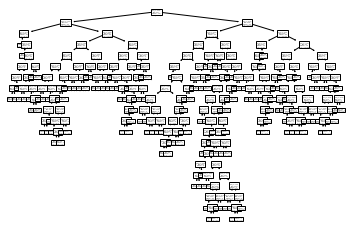

In [ ]:
plot_tree(Tree_model)

Here a function is imported to check the accuracy of the model. It will be used and explained again later. Right now it's just needed for pruning

In [ ]:
from sklearn.metrics import roc_auc_score

Here, all of the cps from the original model are taken and used to calculate a bunch of different accuracies. This basically just means more and more "branches" of the tree are cut off and the accuracy is checked after each cut. this will be plotted below to see how many branches we can get away with cutting off/ how many we need to cut off in order to get good accuracy.

In [ ]:
cp_values = list(cps['ccp_alphas'])
rs = []

for cp in cp_values:

  test_model = DecisionTreeClassifier(ccp_alpha = float(cp),max_features='sqrt', random_state = 540).fit(X_train,np.ravel(y_train['PATIENTSTATUS']))
  test_score = test_model.predict_proba(X_test)[:,1]
  rs.append(roc_auc_score(y_test,test_score))


Here the complexity scores are plotted against the accuracy. Accuracy increases until a cp value of about .0037 then drops again. If our only priority was accuracy this would be the value we choose, but we also want to get rid of as many branches as possible so we can read it better. As a result we'll keep on cutting so long as the accuracy doesn't get too much worse this takes us to a cp value of about .0040

In [ ]:
px.scatter(x=cp_values,y=rs,title = 'Complexity scores for pruning', labels = dict(x='cp value', y = 'accuracy'))

The complexity score chosen from the previous chart is now plugged into the decision tree model again and this creates a "pruned" model

In [ ]:
Prune_model = DecisionTreeClassifier(ccp_alpha = .004292374, random_state = 540).fit(X_train,np.ravel(y_train['PATIENTSTATUS']))

Here the pruned model is plotted. Notice that there is a lot less text and a lot cleaner of a tree. Looking closely at the tree you'll see that it refers tp columns of the data (e.g. X[372]) I will translate which values these are that tree uses to come to it's conclusion below. The gini basically coresponds to the importance of the questions and more important questions are asked first.

[Text(133.92000000000002, 201.90857142857143, 'X[883] <= -0.485\ngini = 0.471\nsamples = 1280\nvalue = [486, 794]'),
 Text(50.220000000000006, 170.84571428571428, 'X[883] <= -1.434\ngini = 0.47\nsamples = 405\nvalue = [252, 153]'),
 Text(33.480000000000004, 139.78285714285715, 'gini = 0.304\nsamples = 107\nvalue = [87, 20]'),
 Text(66.96000000000001, 139.78285714285715, 'X[454] <= -0.073\ngini = 0.494\nsamples = 298\nvalue = [165, 133]'),
 Text(33.480000000000004, 108.72, 'X[449] <= -1.029\ngini = 0.444\nsamples = 165\nvalue = [110, 55]'),
 Text(16.740000000000002, 77.65714285714284, 'gini = 0.493\nsamples = 107\nvalue = [60, 47]'),
 Text(50.220000000000006, 77.65714285714284, 'gini = 0.238\nsamples = 58\nvalue = [50, 8]'),
 Text(100.44000000000001, 108.72, 'X[262] <= 0.424\ngini = 0.485\nsamples = 133\nvalue = [55, 78]'),
 Text(83.70000000000002, 77.65714285714284, 'X[411] <= -1.102\ngini = 0.452\nsamples = 113\nvalue = [39, 74]'),
 Text(66.96000000000001, 46.59428571428572, 'gini = 0

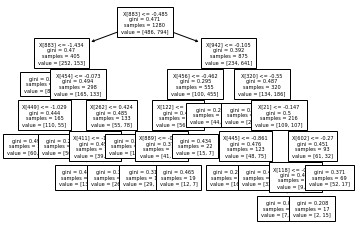

In [ ]:
plot_tree(Prune_model, fontsize=4)

Below are the variables used by the decsision tree for it's tree model. A lot less than 1000!

In [ ]:
tree_list = list(X_train[X_train.columns[Prune_model.feature_importances_ != 0]].columns)
tree_list

['BETA-CRYPTOXANTHIN',
 'XDAYS45',
 'ACTLDAYS',
 'VB12DOS',
 'BBPSYRES',
 'DSODASV',
 'AGESTART',
 'AGEQUIT',
 'BRND1TAR',
 'BRND2FIL',
 'MILKC',
 'DOBYEAR',
 'HHINC',
 'SEERSUMMSTAGE2000_x']

I will translate these variables properly later, in the interpretability portion, but for now, you can see what questions these correspond too from the surveys.
[nan,
 'Days per week of exercise at 45 years',
 'Days per week taking acetylsalicylic acid',
 'Had abnormal breast biopsy results',
 'Diet soda serving size',
 'Age first smoked',
 'Age last smoked',
 'Brand smoked most recently tar',
 'Prior brand smoked most filter',
 'How often did you eat milk on cereal',
 'Year of Birth',
 'Household income']

 Due to all of the transformations done to the data, some of the variables are not easily translateable back to the question that generated them. They produce a nan, or nothing, and can be referred to in the file detailing all the questions to translate them.




######Appendix (Previous decision tree models)

This version of this project is actually a redo of the work that I had originally done. The initial version is riddled with mistakes, as I was still learning the basics back then, but here is a display of the decision tree modelling and pruning done back then.

For convenience I'm going to make a new file out of the overall merged dataframe from the beginning of this notebook. In my previous version I did it a long and tedious way, but I can simplify it with the current work I've done.

In [ ]:
(train_barcodes.merge(Combined_df, on = 'QBARCODE')).to_csv('train_merge.csv', index = False)
(test_barcodes.merge(Combined_df, on = 'QBARCODE')).to_csv('test_merge.csv', index = False)


In [ ]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Import data

In [ ]:
%%R

tumor_train_all <- read.csv('/content/train_merge.csv',header = T)
test_train_all <- read.csv('/content/test_merge.csv',header = T)

Install and import a library that I'm not sure if I actually needed

In [ ]:
%%R
install.packages('plyr')
library(plyr)


R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/plyr_1.8.6.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 401191 bytes (391 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write t

Install and import the library required for decision trees

In [ ]:
%%R
install.packages('rpart')
library('rpart')

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/rpart_4.1-15.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 639286 bytes (624 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write

Set parameters for decision tree. Fit initial tree model

In [ ]:
%%R

model.control <- rpart.control(minsplit=15, xval=10, cp=0)

tree.fit<- rpart(as.factor(PATIENTSTATUS)~.-QBARCODE, data=tumor_train_all, method='class', control = model.control)

Plot unruly decision tree

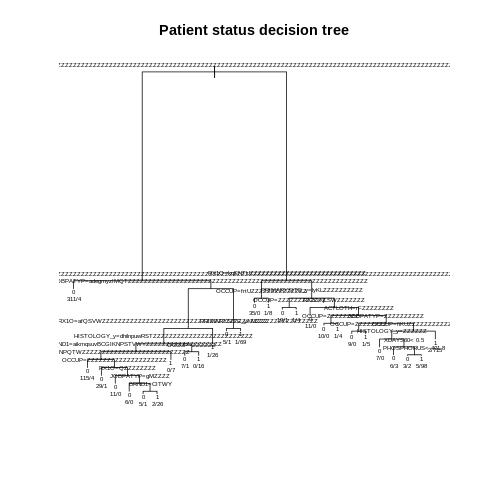

In [ ]:
%%R
plot(tree.fit,main='Patient status decision tree')
text(tree.fit, use.n=TRUE, cex = .5)

choose a cp to decide how many branches to prune, similar to earlier

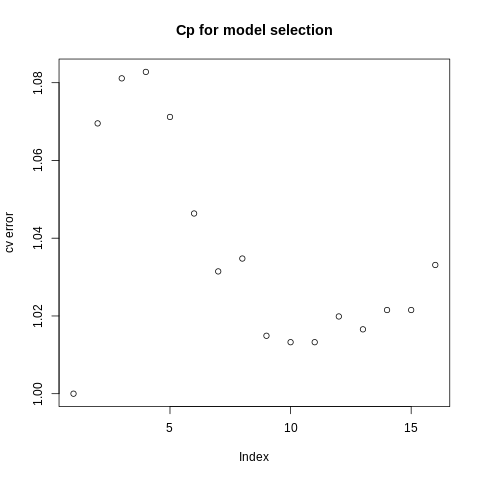

In [ ]:
%%R
plot(tree.fit$cptable[,4], main = "Cp for model selection", ylab = 'cv error')


Prune tree

In [ ]:
%%R
prune.status <- prune(tree.fit, cp = tree.fit$cptable[9, 1])


Plot pruned tree

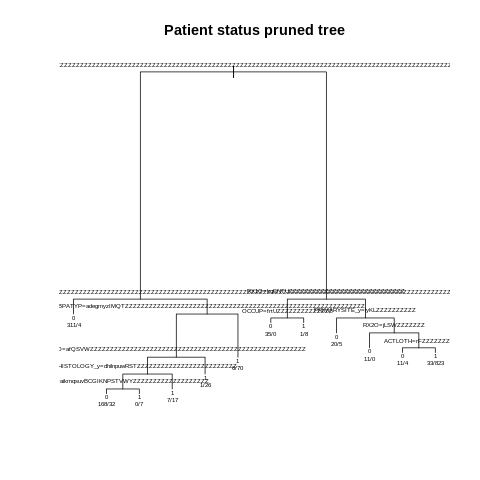

In [ ]:
%%R
plot(prune.status, main='Patient status pruned tree')
text(prune.status, use.n=TRUE, cex = .5)

List out the importances of variables based on the pruned tree. Higher numbers are more important

In [ ]:
%%R
prune.status$variable.importance

        OCCUP      JOBPATYP          RX1O         CNCR1 PRIMARYSITE_y 
   396.500148    229.282833    171.139181    108.001366     97.761390 
         RX2O       RX1OTH1       DOBYEAR       ACTLOTH       RX2OTH1 
    67.673569     63.032014     50.609193     36.862878     32.131730 
        BRND1   HISTOLOGY_y      PRDNOTH1      CNCR1STD         BRND2 
    26.263845     17.976882      8.602764      8.465882      3.561101 
      NPRXOTH       ACETOTH      ANTAOTH1 
     3.301390      1.363478      1.363478 


Plot variable importance so it can be seen just how much more important certain variables are

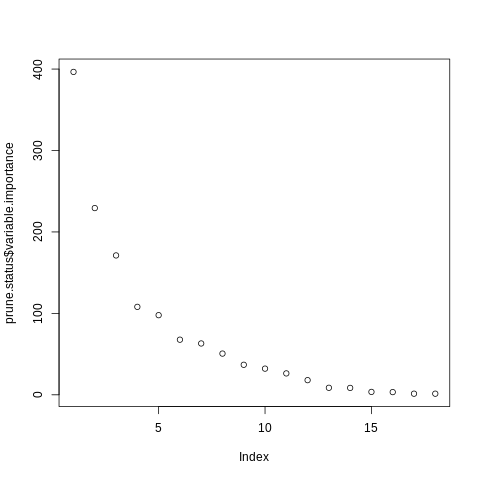

In [ ]:
%%R
plot(prune.status$variable.importance)

Fit a new decision tree only using the variables that were deemed important. This is a version of feature selection.

In [ ]:
%%R
optimized.tree.fit<- rpart(as.factor(PATIENTSTATUS)~OCCUP+JOBPATYP+RX1O+CNCR1+PRIMARYSITE_y+RX2O+RX1OTH1+DOBYEAR+ACTLOTH+RX2OTH1+BRND1+HISTOLOGY_y+CNCR1STD, data=tumor_train_all, method='class', control = model.control)

Plot this new tree, unpruned

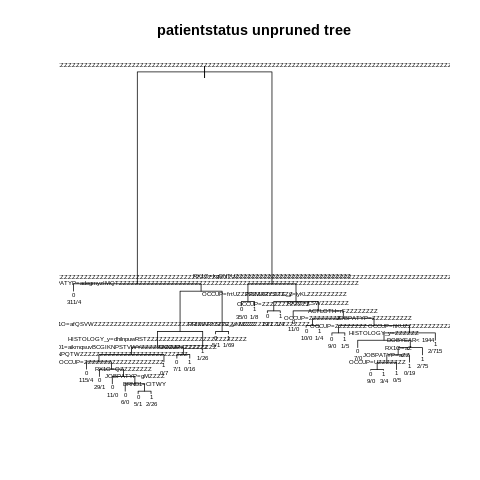

In [ ]:
%%R
plot(optimized.tree.fit, main='patientstatus unpruned tree')
text(optimized.tree.fit, use.n=TRUE, cex = .5)

Plot cps for selection again

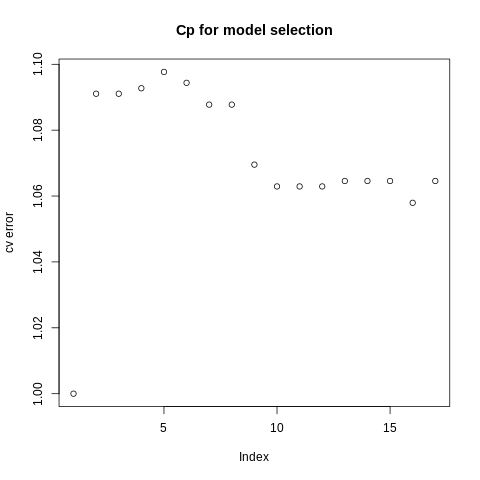

In [ ]:
%%R
plot(optimized.tree.fit$cptable[,4], main = "Cp for model selection", ylab = 'cv error')


Prune new tree and plot it.

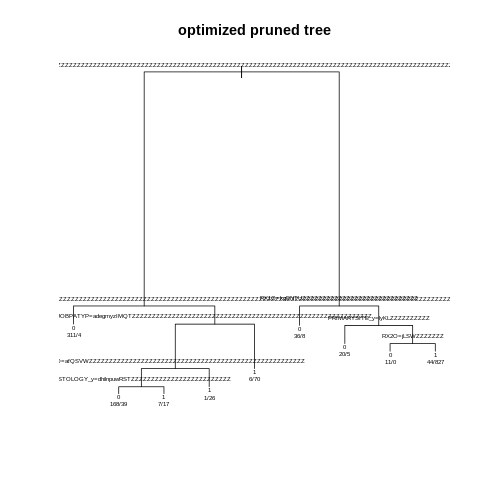

In [ ]:
%%R
prune.opt <- prune(optimized.tree.fit, cp = optimized.tree.fit$cptable[8, 1])
plot(prune.opt, main='optimized pruned tree')
text(prune.opt, use.n=TRUE, cex = .5)

####Random forest Model Training

Now the random forest model is trained. features are concurrently eliminated as the model is built using RFECV standing for recursive feature elimination cross validated. First the data is split into 5 subsets. 4 are used to train the model an one is used for accuracy check. Every subset gets a chance at being the test set. The model starts by using all variables for a random forest fit using 200 trees. the average accuracy across the 5 different test sets is taken, then 25 variables are eliminated. This is repeated until all but 25 variables are taken away. The accuracies are then  compared and the one that has the best tradeoff of accuracy and low variables is used.

Random forest works by using a bunch of decision trees like the one made in the previous section (200 in this case) and randomly chooses which variables it has access to to try to make a decision. All of these different trees are then polled to see what the majority of the trees think any new piece of data should be classified as.

In [ ]:
#Do feature selection based on the outcomes of random forests with 200 trees
#RFECV uses all features, then starts eliminating features, based on the accuracy of a random forest model
#Fit with these features. It also uses 5 fold cross validation while doing this, to make sure there aren't weird splits when
#testing
log_selector = RFECV(estimator = RandomForestClassifier(200,random_state = 6543), step = 25,min_features_to_select = 25,n_jobs=-1).fit(X_train,np.ravel(y_train['PATIENTSTATUS']))

##Results_Model-Performance_and_Interpretability

Here we import functions useful for determining the accuracy of our models. ROC_AUC_SCORE uses true and false positives to come up with an accuracy, more suitable than regular accuracy for problems like this. the roc curve visualizes the ratio of true to false positives, and the confusion matrix visualizes it tabularly.

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_roc_curve

###Decision Tree Results

First the decision tree is evaluated. The test set is predicted

In [ ]:
Prune_hat = Prune_model.predict(X_test)
Prune_score = Prune_model.predict_proba(X_test)[:,1]

Below is the confusion matrix. The 0 and 1 on top refer to true patient status, while the side 0 and 1 are the predicted status. You want these to agree, so the less numbers there are in the top right and bottom left cells the better.

In [ ]:
pd.DataFrame(confusion_matrix(y_test,Prune_hat))

,0,1
0,64,54
1,40,162


The ROC AUC score is shown below. .5 is the worst while 1 is the best. Anything below .5 basically means the model is working backwards (e.g. guessing heads every time it should be guessing tails). .73 is then middle of the road

In [ ]:
roc_auc_score(y_test,Prune_score)

0.7382320859204564

the roc curve shows the proportion of true positives to false positives. This is best when hugging the left wall and ceiling. As it stands the false positive rate increases with the true positive rate increases faster than the false until about .67 true positive then false positive starts increasing faster, somewhat negating any further increases in true positive. this makes the .67 somewhat optimal.

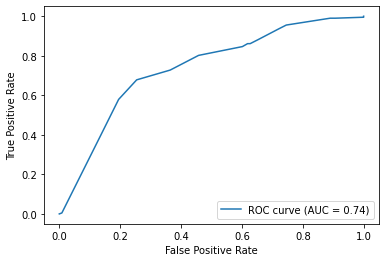

In [ ]:
plot_roc_curve(Prune_model,X_test,y_test, name = 'ROC curve')

###Random Forest Results

Now the random forest predicts the test set

In [ ]:
y_hat = log_selector.predict(X_test)
y_score = log_selector.predict_proba(X_test)[:,1]

Here is the confusion matrix for the random forest. Works as described above in the decision tree results section

In [ ]:
pd.DataFrame(confusion_matrix(y_test,y_hat))

,0,1
0,50,68
1,21,181


The auc score for random forest is about .77. This is higher than the decision trees.

In [ ]:
roc_auc_score(y_test,y_score)

0.7689629132404766

ROC curve works the same as described above as well. This one is optimal around .8, as the rate of increase of false positive rate increases faster after this point.

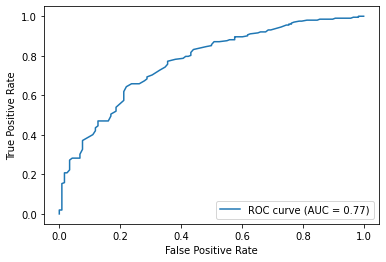

In [ ]:
plot_roc_curve(log_selector,X_test,y_test, name = 'ROC curve')

### Feature Importance

Now we will strive to  interpret which variables are important

The number below tells how many variables were chosen by the RFECV discussed above for the optimal model.

In [ ]:
#This tells us that how many columns were deemed important enough and selected for the final model.

log_selector.n_features_

461

Here I plot the accuracies yielded by each feature subset gone through by RFECV, to illustrate how it chose 460 features. The general trend can be seen to increase until around 18 rounds of feature elimination (around 450 features eliminated, since 25 features are eliminated in each round) then starts to decrease a bit. If I were eliminating features by hand I'd have probably eliminated more as the general trend does not drop by that much, to achieve the very highest accuracy possible it is okay for the model to have just stopped at the highest accuracy

In [ ]:
#This shows the CV accuracy after each round of eliminating 25 features in the RFECV random forest checks.
#Following the general trend,the accuracy rises to a peak, then starts to drop again, Allowing the model to choose
# a subset of features based on the tradeoff between accuracy and complexity 
px.scatter(y=log_selector.grid_scores_,trendline= 'lowess', title = 'Accuracy during each round of feature elimination',labels=dict(x='iteration round', y="Accuracy")
)

Now the specific columns used by the model are acquired

In [ ]:
#Get which columns are used for naming
log_sel_ind = log_selector.get_support()

In [ ]:
#Selected Columns
sel_columns = list(X_train.columns[log_sel_ind])

Since the variables are not super explicit I now attempt to translate the questions back into their orginal questions. To do this the questions need to be pulled from the file listing them and associated with the corresponding variables.

In [ ]:
#For finding which questions were important from the selected variable names
var_list = list(All_files['DBBR Questionnaire Data Dictionary']['VARNAME'])
up_var_list = [var.upper() for var in var_list]
quest_list = list(All_files['DBBR Questionnaire Data Dictionary']['VARIABLE'])

quest_dict = dict(zip(up_var_list,quest_list))

As touched on before, due to the transformation of the data performed throughout this project, the variables are not in the same form that they originated. As such they are not recognized as being the exact same variables and raise errors when trying to associate them with the method that I've chosen. To circumvent this I use "try-except" in the code below. This basically tells the computer not to sweat it if it can't understand what I'm trying to do and to just move on to the next variable to translate. This leaves some variables untranslated, and some translated as nan, but allows most variables to translate.

In [ ]:
#Compiling important questions 

Sel_quests = []

for col in sel_columns:
    
    if 'x' in col or 'y' in col:
        
        co = col.split('_')[0]

    else:
        
        co = col
        
    try:
    
        Sel_quests.append(quest_list[up_var_list.index(co)])
        
    except:
        
        continue

Remember the questions I said that the decision tree variables corresponded to? this is where I found them, using the same method as above.

In [ ]:
[quest_dict[col] for col in  tree_list if col in quest_dict.keys()]

[nan,
 'Days per week of exercise at 45 years',
 'Days per week taking acetylsalicylic acid',
 'Had abnormal breast biopsy results',
 'Diet soda serving size',
 'Age first smoked',
 'Age last smoked',
 'Brand smoked most recently tar',
 'Prior brand smoked most filter',
 'How often did you eat milk on cereal',
 'Year of Birth',
 'Household income']

Below are the translated variables from the random forest model. Since there are around 500, you have to scroll through to see them, but they're mostly there

In [ ]:
#These are at least some of the questions used by the model to predict the patient class
[q for q  in Sel_quests if q != 'nan']

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 'Current frequency of frying food ',
 'Current frequency of eating vegetables',
 'Current frequency of eating fruit',
 'Current days/wk  exercise 20+ minutes ',
 'At what age began physically active job',
 'How many years worked physically active job',
 'Level of physical activity compared to others your age ',
 'Years walked for exercise',
 'Days per week walked',
 'Minutes per day walked',
 'Usual pace walked',
 'Lift weights or weight machine in past 10 yrs',
 'Years lifted weights',
 'Days per week lifted weights',
 'Minutes per day 

##Create Submission File

Now the competition assigned test set is predicted using the random forest model since it had higher accuracy

In [ ]:
#Now to predict the test set based on the selector
test_samples = test_barcodes.merge(barc_het_frame, on = 'QBARCODE')
test_samples.drop('QBARCODE', axis=1, inplace= True)

In [ ]:
submission_preds = pd.DataFrame(log_selector.predict_proba(test_samples)[:,1], columns = ["PatientStatus"])

In [ ]:
submission = pd.concat([test_barcodes, submission_preds], axis = 1 )
submission.columns = ['qbarcode',"PatientStatus"]

In [ ]:
submission.to_csv('Good_submission.csv', index = False)

Since this is a redo of this project the score does not show publicly, but the score on the public leaderbord is .75703

In [ ]:
##I don't know how to access the true class data from the kaggle competition, but the score on the public leaderbord
#From this redone project in a late submission was .75703